图算法广泛应用于存在大量非结构化网状数据的领域，如社交网络、金融、交通、搜索等，是一种非常简单易用且有效的机器学习算法，算法的思想也非常容易理解。而网络安全领域在风控、威胁情报方面也有很多非结构化网状数据，所以也会用到图算法。

如何使用有向图识别WebShell，如何使用有向图识别僵尸网络中的同一黑产团体，将结合搜索广告介绍神秘的知识图谱，以及知识图谱在风控领域的应用，包括检测账户被盗、撞库以及简单的刷单，还有在威胁情报领域的应用，包括挖掘后门文件的潜在联系以及域名的潜在联系等。

在现实世界中，有种关联关系难以用数据库的表结构来表示，比如微博的粉丝关系、偶像剧中的N角恋、多个域名之间的注册关系等，于是图这种古老的数据结构就派上了用场。一般认为，如果给图的每条边规定一个方向，那么得到的图称为有向图，其边也称为有向边。在有向图中，与一个节点相关联的边有出边和入边之分，而与一个有向边关联的两个点也有始点和终点之分。相反，边没有方向的图称为无向图。

图的聚类算法，最简单的一种实现叫做连通分支，其原理如图所示。所谓连通分支，指的是图中由边连接在一起的一组顶点，不要求顶点之间必须两两相连，但是连通分支的任意两个顶点之间，至少存在一条路径，计算连通分支时不区分有向图和无向图。（两顶点间至少要有一个连接，没有连接，无法构成关系）

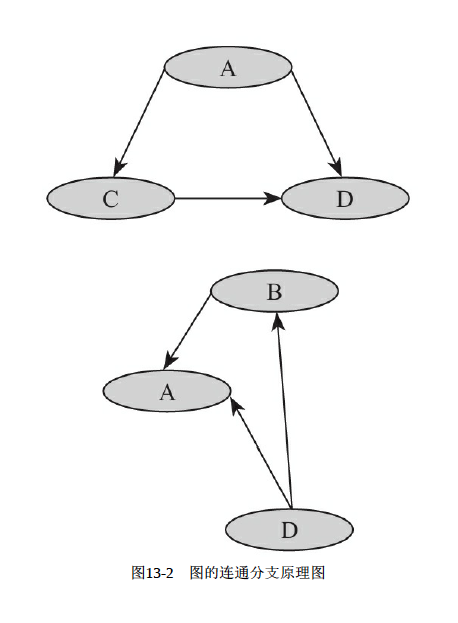

Neo4j是一个高性能的图形数据库，它将结构化数据存储在网络上而不是表中，因其具有嵌入式、高性能、轻量级等优势，越来越受到人们关注。

In [8]:
# 导入库并连接数据库：

from neo4j import GraphDatabase, basic_auth
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j","ntd*51sa"))
session = driver.session()

In [9]:
# 插入人物节点以及关系数据：

insert_query = '''
        UNWIND {pairs} as pair
        MERGE (p1:Person {name:pair[0]})
        MERGE (p2:Person {name:pair[1]})
        MERGE (p1)-[:KNOWS]-(p2);
        '''
data = [["Jim","Mike"],["Jim","Billy"],["Anna","Jim"],
        ["Anna","Mike"],["Sally","Anna"],["Joe","Sally"],
        ["Joe","Bob"],["Bob","Sally"]]

session.run(insert_query, parameters={"pairs": data})

In [10]:
# 查询

foaf_query = '''
        MATCH (person:Person)-[:KNOWS]-(friend)-[:KNOWS]-(foaf)
        WHERE person.name = {name}
        AND NOT (person)-[:KNOWS]-(foaf)
        RETURN foaf.name AS name
        '''

results = session.run(foaf_query, parameters={"name": "Joe"})

for record in results:
    print(record["name"])
    
common_friends_query = """
        MATCH (user:Person)-[:KNOWS]-(friend)-[:KNOWS]-(foaf:Person)
        WHERE user.name = {user} AND foaf.name = {foaf}
        RETURN friend.name AS friend
        """

results = session.run(common_friends_query, parameters={"user": "Joe", "foaf": "Sally"})

for record in results:
    print(record["friend"])
    
connecting_paths_query = """
        MATCH path = shortestPath((p1:Person)-[:KNOWS*..6]-(p2:Person))
        WHERE p1.name = {name1} AND p2.name = {name2}
        RETURN path
        """

results = session.run(connecting_paths_query, parameters={"name1": "Joe", "name2": "Billy"})

for record in results:
    print (record["path"])

Anna
Bob
<Path start=<Node id=3 labels={'Person'} properties={'name': 'Joe'}> end=<Node id=6 labels={'Person'} properties={'name': 'Billy'}> size=4>


使用有向图来识别webshell，我们知道webshell会有很多的访问特征，大马一般会将恶意的程序放在其它机器上，也就说会是一个不同的域名，这就会有一个出入度都为1的连接指向，而出入度为0的情况就是自己指向自己。

在生产环境实际使用中，我们遇到的误报分为以下几种：

* 主页，各种index页面；
* Phpmyadmin、Zabbix等运维管理后台；
* Hadoop、ELK等开源软件的控制台；
* API接口。

这些通过短期加白可以有效解决，比较麻烦的是扫描器对结果的影
响，这部分需要通过扫描器指纹或者使用高大上的人机算法来去掉干
扰。

黑产团伙通过控制僵尸网络，主要达到以下几个目的：

* 发送广告邮件；
* 发起DDoS攻击；
* 发起恶意广告点击展现请求；
* 全网扫描漏洞并自动化渗透具有漏洞的主机，不断扩充肉鸡的规模

知识图谱本质上可以认为是图的一种具体应用，它大量集成了互联网上的各类数据，从而进一步挖掘出了数据的潜在联系与价值。在安全领域应用知识图谱，可以挖掘数据之间潜在的联系，结合这些潜在的联系可以大大扩展我们的数据分析思路。

传统的风控策略主要基于模型和策略，这在传统行业已然有着很大的市场，但是在互联网环境下，职业黑产团伙以及羊毛党的加入，传统的风控策略已经大打折扣。如何利用互联网上各类数据，挖掘蛛丝马迹，进行风控呢？知识图谱，作为关系的直接表示方式，可以很好地解决这两个问题。首先，知识图谱提供非常便捷的方式来添加新的数据源。其次，知识图谱本身就是用来表示关系的，这种直观的表示方法可以帮助我们更有效地分析复杂关系中存在的特定的潜在风险。

检测疑似账号被盗

盗号是互联网业务中常见的恶意行为。盗号的渠道也非常多，从暴力破解到撞库都可能导致账户被盗，单纯依赖用户名和密码认证已经无法保障账户的安全。我们使用脱敏的测试数据来演示疑似账户被盗的情况

字段含义分别为：
* uid，用户名；
* ip，登录IP地址；
* tel，安装微软邮件客户端的手机的手机号；
* activesyncid，安装微软邮件客户端的手机对应activesyncid，该id全局唯一，与硬件绑定，类似微软在PC上的guid。

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

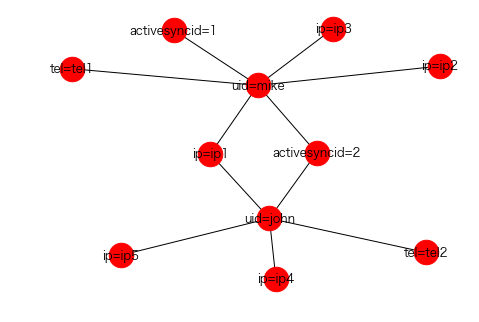

In [13]:
sample = './数据集/KnowledgeGraph/sample1.txt'
f = open(sample , 'r')
G = nx.Graph()
for line in f.readlines():
    line = line.strip('\n')
    uid, ip, tel, activesyncid = line.split(',')
    G.add_edge(uid, ip)
    G.add_edge(uid, tel)
    G.add_edge(uid, activesyncid)
nx.draw(G, with_labels=True, node_size=600)
plt.show()

分析只有mike同时登录过两台设备，可认定为疑似威胁。

检测疑似撞库攻击

撞库是黑客通过收集互联网已泄露的用户和密码信息，生成对应的字典表，尝试批量登录其他网站后，得到一系列可以登录的用户。很多用户在不同网站使用的是相同的账号密码，因此黑客可以通过获取用户在A网站的账户从而尝试登录B网站，这就可以理解为撞库攻击

字段含义分别为：

* uid，用户名；
* ip，登录IP地址；
* login，登录状态，yes表明登录成功，no表明登录失败；
* ua，浏览器的ua字段，通常结合ip和ua字段可以在一定程度标识一个用户或者设备。

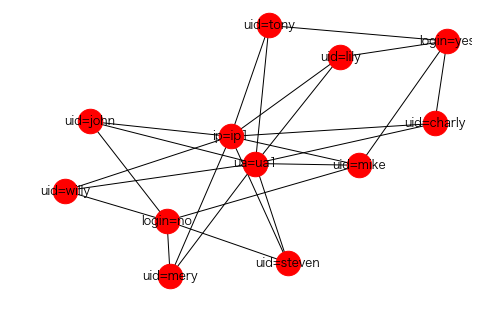

In [14]:
sample = './数据集/KnowledgeGraph/sample2.txt'
f = open(sample , 'r')
G = nx.Graph()
for line in f.readlines():
    line = line.strip('\n')
    uid, ip, login, ua = line.split(',')
    G.add_edge(ip, uid)
    G.add_edge(ua, uid)
    G.add_edge(uid, login)
nx.draw(G, with_labels=True, node_size=600)
plt.show()

从拓扑图可以看出来，大量账户从ip1登录，并且ua字段相同，登录失败和成功的情况均存在，疑似发生了撞库攻击行为。通常情况下，同一IP不会出现大量登录行为，即使办公网出口这种人员密集的地方，也应该主要是登录成功为主，不应该登录成功与失败数量均比较大。

检测疑似刷单

国内O2O的大肆补贴，滋生了一个产业链，即所谓的“羊毛党”和“刷单”。有一批人对搜集各大电子商城、银行、实体店等各渠道的优惠促销活动、免费业务之类的信息产生了浓厚的兴趣。他们有选择地参与活动，从而以相对较低成本甚至零成本换取物质上的实惠。这一
行为被称为“薅羊毛”，而关注与热衷于薅羊毛的群体就被称作“羊毛党”。早前，“羊毛党”们主要活跃在O2O平台或电商平台。另外随着2015年互联网金融的发展，一些网贷平台为吸引投资者常推出一些收益丰厚的活动，如注册认证奖励、充值返现、投标返利等，催生了以此为生的投资群体，他们也被称为“P2P羊毛党”。这部分用户与网购羊毛党不同，只关注互联网金融产品。

刷单是店家付款请人假扮顾客，用以假乱真的购物方式提高网店的排名和销量，从而获取好评吸引顾客，即由卖家提供购买费用，帮指定的网店卖家购买商品提高销量和信用度，并填写虚假好评的行为。通过这种方式，网店可以获得较好的搜索排名，比如，在平台搜索时按“销量”搜索，该店铺因为销量大（即便是虚假的）会更容易被买家找到。刷单一般可分为两种：一是单品刷销量为做爆款等做准备；二是刷信誉以提高店铺整体信誉度。还有一种刷单更为直接，以外卖软件为例子，同一个人使用两台手机，分别安装客户下单软件和商家接单软件，一下一接，捞取补贴

字段含义分别为：

* hid，硬件指纹，唯一标识一台设备；
* uid，App的登录用户名；
* app，App的名称。

字段含义分别为：

* hid，硬件指纹，唯一标识一台设备；
* uid，App的登录用户名；
* action，用户行为，是下单还是接单。

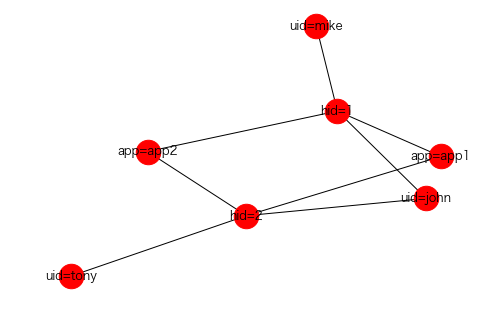

In [20]:
sample = './数据集/KnowledgeGraph/sample3.txt'
f = open(sample , 'r')
G = nx.Graph()
for line in f.readlines():
    line = line.strip('\n')
    hid, uid, app = line.split(',')
    G.add_edge(hid, uid)
    G.add_edge(hid, app)
nx.draw(G, with_labels=True, node_size=600)
plt.show()

两台设备hid1和hid2登录账户不一样，但是他们共同安装的App2上的登录用户名相同，从而可以判断这两台设备属于同一个人，该人疑似使用这两台设备分别扮演买家和卖家进行刷单行为。

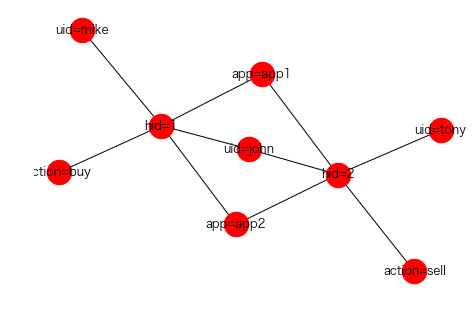

In [21]:
sample = './数据集/KnowledgeGraph/sample4.txt'
f = open(sample , 'r')
for line in f.readlines():
    line = line.strip('\n')
    hid, uid, action = line.split(',')
    G.add_edge(hid, uid)
    G.add_edge(hid, action)
nx.draw(G, with_labels=True, node_size=600)
plt.show()

John账号在两台设备上登录，一个buy，另一个sell，以此认为可能的刷单行为。

知识图谱在威胁情报领域的应用

挖掘后门文件潜在联系

黑产通常通过传播后门文件入侵主机，组织起庞大的僵尸网络。后门文件通常通过连接C&C服务器的域名来监听控制指令，后门文件中硬编码少量C&C服务器的域名，然后自动化下载最近的C&C服务器列表。通过静态分析后门文件中硬编码的域名，关联分析域名和文件之间
的关系，可以挖掘出后门文件之间的潜在联系。

* md5，后门文件md5值；
* domain，C&C域名。

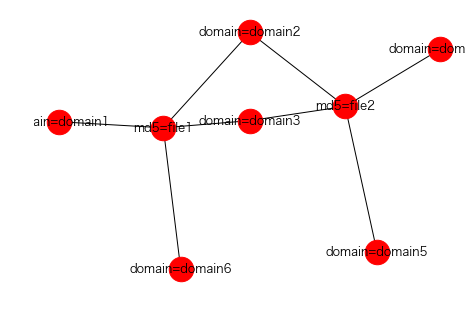

In [12]:
sample = './数据集/KnowledgeGraph/sample6.txt'
f = open(sample , 'r')
G = nx.Graph()
for line in f.readlines():
    line = line.strip('\n')
    file, domain = line.split(',')
    G.add_edge(file, domain)
nx.draw(G, with_labels=True, node_size=600)
plt.show()

挖掘域名潜在联系

黑产通常会注册大量的域名用于C&C服务器、钓鱼等，注册域名时会登记注册人的邮箱息，通过关联IP、注册邮箱、域名可以挖掘潜在的关联关系

字段含义分别为：

* mail，注册邮箱；
* domain，注册域名；
* ip，注册域名对应的IP。

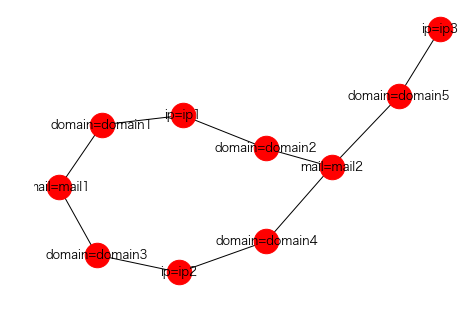

In [24]:
sample = './数据集/KnowledgeGraph/sample5.txt'
f = open(sample , 'r')
G = nx.Graph()
for line in f.readlines():
    line = line.strip('\n')
    mail, domain, ip = line.split(',')
    G.add_edge(mail, domain)
    G.add_edge(domain, ip)
nx.draw(G, with_labels=True, node_size=600)
plt.show()

一般要是僵尸网络使用的域名注册，会有一个域名多个IP，和多个域名一个IP